In [168]:
# Import all the libraries
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None  # default='warn', Mutes warnings when copying a slice from a DataFrame.
pd.set_option('display.max_columns', None)
import glob
import datetime
import os
import json
from io import StringIO
import matplotlib.pyplot as plt
%matplotlib inline

For this exploratory analysis we used the cluster to randomly sample the data and retrieve the metadata for the items that appear in our review sample.

In [169]:
# Paths to the data and metadata folders.
DATA_FOLDER = 'data/'
META_FOLDER = DATA_FOLDER + 'meta/'

In [137]:
# Load one data file
def load_one_file(path):
    with open(path) as f:
        return [json.loads(line) for line in f]

# Load one metadata file. The rows aren't proper JSON
# but they can be parsed using python's eval function
# as per the dataset's web page.
def load_one_meta_file(path):
    with open(path) as f:
        return [eval(line) for line in f]

# The sample we extracted is still too large, so we'll only use the first 100 files
data_files = glob.glob(DATA_FOLDER + 'part-000*')
data = sum(map(load_one_file, data_files), [])

# The meta folder contains metadata for all the items we were interested in.
meta_files = glob.glob(META_FOLDER + '*')
meta = sum(map(load_one_meta_file, meta_files), [])

# Create the two dataframes
df = pd.DataFrame(data)
meta_df = pd.DataFrame(meta)

In [170]:
# Join the dataframes. Since our analysis relies on the metadata for a good part
# we have to remove any reviews for which metadata is not available.
joined = pd.merge(df, meta_df, how='inner')

# Parse the review time as a DateTime and add a review month column
joined['reviewTime'] = pd.to_datetime(joined.unixReviewTime, unit='s')
joined['reviewMonth'] = joined.reviewTime.map(lambda t: t.month)

In [139]:
joined.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,brand,categories,description,imUrl,price,related,salesRank,title,reviewMonth
0,B005FYPK9C,"[0, 0]",5.0,I was sketchy at first about these but once yo...,2013-01-08,A000008615DZQRRI946FO,mj waldon,great buy,1357603200,NaN,"[[Clothing, Shoes & Jewelry, Shoes & Accessori...",NaN,http://ecx.images-amazon.com/images/I/415OJXEA...,NaN,"{'also_bought': ['B004KNWSBM', 'B00CIM6I8G', '...",{'Shoes': 53868},Osiris Men's Cinux Skate Shoe,1
1,0871714779,"[0, 0]",1.0,"Because I have not gotten the book yet, I may ...",2013-05-22,A000096625CHSNKYTYGZN,Melody L Fearn,I Have Not Got It Yet.,1369180800,NaN,[[Books]],NaN,http://ecx.images-amazon.com/images/I/61fWm4Vm...,NaN,{'buy_after_viewing': ['0871711605']},{'Books': 3814395},Welding Inspection Technology; workbook AWS WIT-W,5
2,B00E7OIOVC,"[0, 0]",5.0,Great!,2014-07-03,A0001528BGUBOEVR6T5U,igozingo,Five Stars,1404345600,niceEshop,"[[Home & Kitchen, Kitchen & Dining, Kitchen Ut...",Style flask funnel great to help you fill your...,http://ecx.images-amazon.com/images/I/31gMKQdA...,1.99,"{'also_bought': ['B004TQIB7U', 'B006O1EBHW', '...",{'Kitchen & Dining': 63021},niceEshop(TM) Small Stainless Steel Funnel For...,7
3,B00EXOZ9W8,"[0, 0]",5.0,"My man was more then happy with it, looking fo...",2014-07-02,A00030342K9JCQO8Q7C3L,Joseph Dvorak,Five Stars,1404259200,NaN,"[[Home & Kitchen, Kitchen & Dining, Small Appl...",,http://ecx.images-amazon.com/images/I/41Oc0HaP...,65.81,"{'also_bought': ['B000FAJ0K6', 'B0012UY6XO', '...",{'Kitchen & Dining': 56153},BELLA 14025 Programmable Slow Cooker with Lock...,7
4,1477473939,"[0, 0]",4.0,Reading this seriers was a amazing. It was ver...,2013-01-26,A000443821AD43TOGKNGZ,Uluwehi,Really enjoyed it!,1359158400,NaN,[[Books]],USA Today Best Selling Author Elizabeth Reyes...,http://ecx.images-amazon.com/images/I/51bhuPCO...,4.99,"{'also_bought': ['147522186X', '1475244207', '...",{'Books': 1011147},Making You Mine: The Moreno Brothers,1


In [171]:
# Similarly we don't want any reviews for which the price is either NaN or 0
# or for which the category is NaN
joined = joined.dropna(axis=0, subset=['categories', 'price'])
joined = joined[joined.price != 0]

In [175]:
# See how many reviews are left
print('Remaining reviews: {}'.format(joined.shape[0]))

Remaining reviews: 126535


We can now start to have a look at the distribution of the various features.

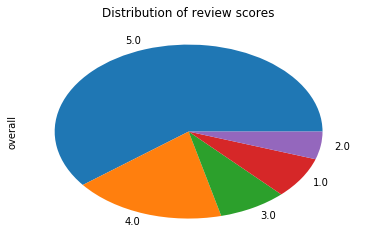

In [176]:
# Review score
joined.overall.value_counts().plot(kind='pie', title='Distribution of review scores')

We can see that more than half of the reviews gave five stars to the product. The low proportion of 1 and 2 star reviews suggests that customers are very likely to be satisfied with the product they purchased.

Let's now consider the number of reviews by month of the year.

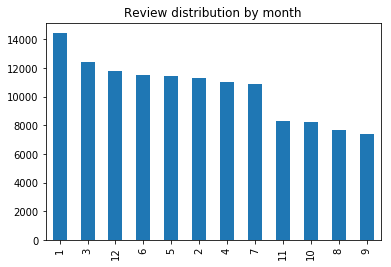

In [178]:
joined.reviewMonth.value_counts().plot(kind='bar', title='Review distribution by month')

The number of reviews seems to be highest during winter and spring and lower during autumn, with January being the month with the highest number of reviews. We were surprised not to see December in the first place considering that winter holidays are traditionally a period of sales.

We can now start looking at the prices of the items. We can define some price bins that will allow us to group the items in price tiers.

In [148]:
# Arbitrarily chosen
price_bins = [
    0,
    10,
    20,
    30,
    40,
    50,
    60,
    70,
    80,
    90,
    100,
    200,
    500,
    1000
]

In [180]:
# Group the items by price tier
group_by_price_tier = joined.groupby(pd.cut(joined.price, price_bins))

First of all we can plot the distribution of the prices of reviewed items.

Text(0.5,1,'Review distribution by price')

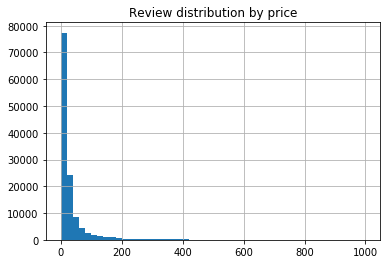

In [181]:
ax = plt.subplot()
joined.price.hist(bins=50, ax=ax)
ax.set_title('Review distribution by price')

The distribution seems to be heavy tailed, with very cheap items making up the majority of the reviews. We can verify if this distribution follows a power law by plotting it on a log-log scale.

Text(0.5,1,'Review distribution by price')

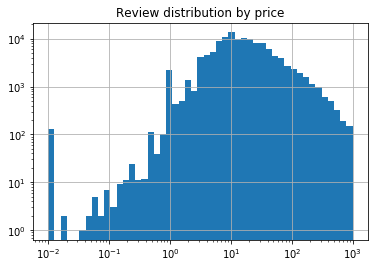

In [182]:
# We need to make logarithmic bins ourselves.
log_bins = np.logspace(np.log10(min(joined.price)), np.log10(max(joined.price)), 50)
ax = plt.subplot()
ax.set_title('Price')
joined.price.hist(ax=ax, log=True, bins=log_bins)
ax.set_xscale('log')
ax.set_title('Review distribution by price')

The distribution doesn't follow a linear relationship on a log-log plot so the distribution is not a power law.

Now let's see the distribution according to the price tiers we defined above.

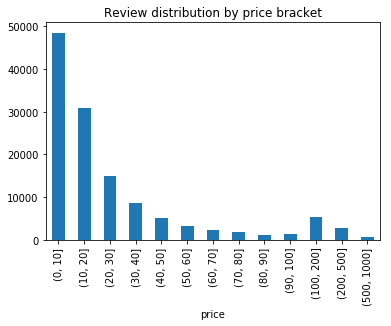

In [183]:
group_by_price_tier.asin.count().plot(kind='bar', title='Review distribution by price bracket')

One of the hypotheses we want to verify is whether the price of an item correlates with its review score, more specifically whether items belonging to a higher price tier are more likely to get better reviews. We can verify that by computing the mean review score for each price tier and displaying that on a bar plot.

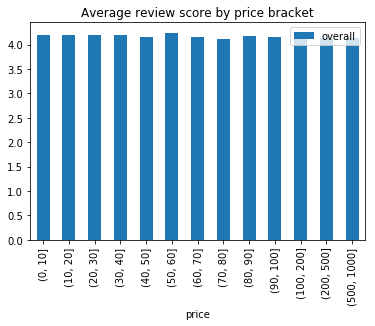

In [157]:
group_by_price_tier[['overall']].mean().plot(kind='bar', title='Average review score by price bracket')

There seems to be no correlation between an item's price tier and its mean review score.

We can also verify whether the month during which a review was written correlates with its score. The presence of such a correlation could indicate that buyers are more likely to give a better review in certain periods of the year than others.

In [184]:
# Group data by the month in which the review was written.
group_by_month = joined.groupby('reviewMonth')
average_month = group_by_month.overall

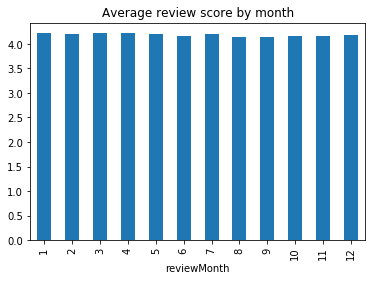

In [185]:
# Plot it
average_month.mean().plot(kind='bar', title='Average review score by month')

Again, we can see that the correlation we hypothesized does not exist in the data. The review scores seem to be independent of the month in which they were written.

We can now begin to group the items according to their category. Each item has a `categories` field which, when not absent, is an array of arrays of strings. Each item can belong to an arbitrary number of categories some of which are subcategories of a larger category. We will first flatten these arrays of arrays in order to make subsequent processing easier.

In [334]:
joined['categories_flat'] = joined.categories.apply(lambda a: [i for sa in a for i in sa])
joined = joined[[(c and bool(c[0])) for c in joined.categories_flat]]

In order to be able to plot aggregate values for each category we need to pick a list of categories that we will use as the main category of the product. One possible choice is the one that was used by the maintainer of the dataset to generate category-specific review files. Of course like in all real-world datasets the data is dirty and so not all products fit in at least one of these categories. Therefore we need to augment this list so that we cover as many items as possible and merge the ones we added into the original ones (for example `All beauty` should be merged with `Beauty`) later on.

In [368]:
# Taken from the dataset's page
main_categories = {
    'Books': 'Books',
    'Electronics': 'Electronics',
    'Movies & TV': 'Movies & TV',
    'CDs & Vinyl': 'Music',
    'Clothing, Shoes & Jewelry': 'Clothing, Shoes & Jewelry',
    'Home & Kitchen': 'Home & Kitchen',
    'Kindle Store': 'Kindle Store',
    'Sports & Outdoors': 'Sports & Outdoors',
    'Cell Phones & Accessories': 'Electronics',
    'Health & Personal Care': 'Health & Personal Care',
    'Toys & Games': 'Toys & Games',
    'Video Games': 'Video Games',
    'Tools & Home Improvement': 'Tools & Home Improvement',
    'Beauty': 'Beauty',
    'Apps for Android': 'Apps for Android',
    'Office Products': 'Office Products',
    'Pet Supplies': 'Pets',
    'Automotive': 'Automotive',
    'Grocery & Gourmet Food': 'Food',
    'Patio, Lawn & Garden': 'Patio, Lawn & Garden',
    'Baby': 'Baby',
    'Digital Music': 'Music',
    'Musical Instruments': 'Musical Instruments',
    'Amazon Instant Video': 'Amazon Instant Video',
    'Amazon Fashion': 'Clothing, Shoes & Jewelry',
    'Amazon Coins': 'Amazon Coins',
    'Software': 'Computing',
    'Baby Products': 'Baby',
    'Gift Cards': 'Gift Cards',
    'Arts, Crafts & Sewing': 'Arts, Crafts & Sewing',
    'Buy a Kindle': 'Kindle Store',
    'Appliances': 'Home & Kitchen',
    'MP3 Players & Accessories': 'Electronics',
    'Kitchen & Dining': 'Home & Kitchen',
    'All Beauty': 'Beauty',
    'Luxury Beauty': 'Beauty',
    'Computers': 'Computing',
    'Camera & Photo': 'Electronics',
    'Car Electronics': 'Automotive',
    'Gospel': 'Music',
    'Animal Care & Pets': 'Pets',
    'Jazz': 'Music',
    'GPS & Navigation': 'Electronics',
    'Office & School Supplies': 'Office Products',
    'Industrial & Scientific': 'Industrial & Scientific',
    'All Electronics': 'Electronics',
    'Home Improvement': 'Tools & Home Improvement',
    'Classical': 'Music',
    'Magazine Subscriptions': 'Magazine Subscriptions',
    'Alternative Rock': 'Music',
    'Gift Cards Store': 'Gift Cards',
    'Rock': 'Music',
    'Classic Rock': 'Music',
    'Christian': 'Music',
    'Pop': 'Music',
    'Folk': 'Music',
    'R&B': 'Music',
    'Soul': 'Music',
    'International': 'Music',
    'Electronica': 'Music',
    'Rap & Hip-Hop': 'Music',
    'Country': 'Music',
    'Comedy': 'Movies & TV', #??? 
    'New Age': 'Music',
    'Davis': 'Music', #???
    'Wine': 'Food',
    'Trading Cards': 'Toys & Games'
}

In [372]:
# Function that returns an item's main category according
# to the above list, or NaN if none of its categories appear in the list.
def get_main_category(categories):
    for c in categories:
        if c in main_categories:
            return main_categories[c]

    return np.nan

# Derive each product's main category
joined['main_category'] = joined.categories_flat.apply(lambda a: get_main_category(a))
joined = joined.dropna(axis=0, subset=['main_category'])

Plot the distribution of items by main category.

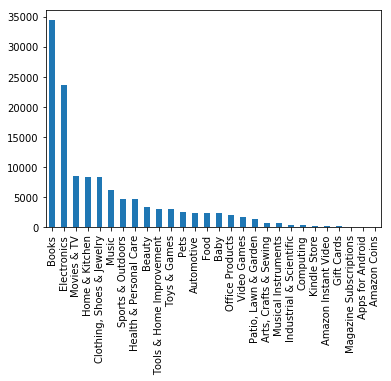

In [374]:
joined['main_category'].value_counts().plot(kind='bar')

The most popular categories by a large margin seem to be books and electronics.

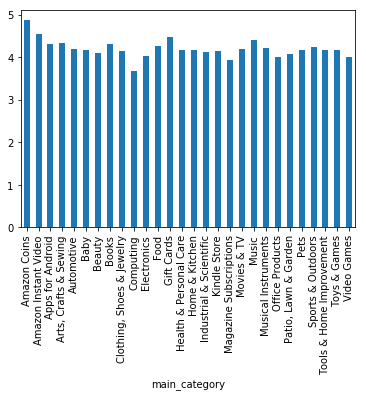

In [373]:
joined.groupby('main_category').overall.mean().plot(kind='bar')

In [5]:
# Create dataframe with needed information
product_reviews = pd.DataFrame({'productID': df.asin,
                                'rating': df.overall,
                                'time': pd.to_datetime(df.reviewTime, format='%m %d, %Y')
                                })
product_reviews['month'] = product_reviews.time.map(lambda t: t.month)
product_reviews.set_index('productID', drop=True, inplace=True)
product_reviews.head()

,rating,time,month
productID,,,
B005FYPK9C,5.0,2013-01-08,1
0871714779,1.0,2013-05-22,5
B00E7OIOVC,5.0,2014-07-03,7
B00EXOZ9W8,5.0,2014-07-02,7
B000G2OYOU,5.0,2012-11-20,11


In [8]:
# Create a product by month table to spot periodicity
# Each entry is the mean of ratings the product gets within certain month
# Nans are filled with 0
product_month = product_reviews.pivot_table(values='rating',
                                            index=product_reviews.index,
                                            columns='month',
                                            fill_value=0)

# Select products with number of reviews larger than the threshold
review_count = product_reviews.index.value_counts()
product_month = product_month.loc[review_count>N_REVIEW_THRESHOLD]

product_month.head()

month,1,2,3,4,5,6,7,8,9,10,11,12
productID,,,,,,,,,,,,
006202406X,3.500000,3.000000,3.2,4.000000,0.0,3.333333,0.0,0.0,0.00,3.000000,3.750000,2.0
006228648X,3.000000,0.000000,1.0,2.333333,4.5,1.500000,0.0,0.0,0.00,2.500000,3.166667,3.0
030758836X,3.777778,4.000000,2.0,3.000000,3.0,3.666667,4.0,3.0,3.60,3.000000,3.800000,2.5
0307588378,4.666667,4.000000,5.0,0.000000,4.0,4.000000,1.0,5.0,4.25,2.666667,2.500000,3.0
038536315X,4.400000,4.666667,3.0,4.500000,5.0,0.000000,0.0,0.0,0.00,0.000000,3.500000,4.0


## ToDo: Spot/measure the periodicity (automatically)